In [1]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import timeit

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################
epochs = 20
batch_size = 10
learning_rate = 0.001
epochs = 20
step_size = 50
gamma = 0.5

weight_decay=1e-4

width_fno = 64
width_fcn = 400
modes = 5

ntrain = 8000
ntest = 2000
# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [28]:
# DATA LOADING
############################## DATA LOADING ########################################
raw_data = scipy.io.loadmat('./datasets/complete_data')
sol = np.asarray(raw_data['solution_data'])

measurement_list = ['measurement_data', 'noise_0005', 'noise_0010', 'noise_0015', 'noise_0020', 'noise_0025', 'noise_0030']
noise_levels = [0, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030]
ntrain = 8000
ntest = 2000

def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y


In [37]:
mes1 = np.asarray(raw_data['measurement_data'])
mes2 = np.asarray(raw_data['noise_0030'])


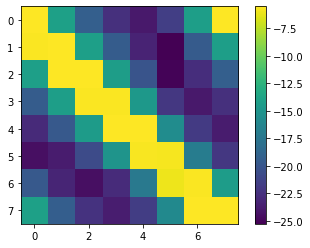

In [43]:
plt.imshow(mes1[10,:].reshape(8,8))
plt.colorbar()
plt.savefig('./images/true_mes')

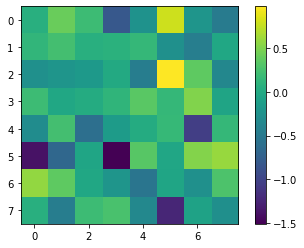

In [42]:
plt.imshow(mes1[10,:].reshape(8,8) - mes2[10,:].reshape(8,8))
plt.colorbar()
plt.savefig('./images/noise_diff')

In [4]:
# DATA LOADING FNO 
######################################################################

def normalize_data_fno(noise):
    mes = np.asarray(raw_data[measurement_list[noise]])


    sol_temp = np.expand_dims(sol,axis = 1 )
    #sol_temp = np.sqeeze(sol_temp)
    mes_temp = np.transpose(np.expand_dims(mes,axis = 1 ),(0,2,1))

    # dimensions of solution space
    y_dim1 = 16
    y_dim2 = 16

    # dimensions of measurement space
    x_dim2 = 8     # no of detectors
    x_dim1 = int(mes.shape[1]/x_dim2)


    # we are solving the inverse problem, so going from measurements, to solutions
    X, y = convert_data(mes_temp, sol_temp)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    y_train = y_train.squeeze()
    y_test = y_test.squeeze()

    y_test = y_test.reshape(y_test.shape[0],y_dim1,y_dim2,1)
    y_train = y_train.reshape(y_train.shape[0],y_dim1,y_dim2,1)

    X_test = X_test.reshape(X_test.shape[0], x_dim1,x_dim2,1)
    X_train = X_train.reshape(X_train.shape[0], x_dim1,x_dim2,1)

    train_dataset = TensorDataset( X_train, y_train )
    test_dataset = TensorDataset( X_test, y_test )

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(X_train.shape, y_train.shape)
    return train_loader, test_loader

In [ ]:
# LOAD FCN DATA
############################## DATA LOADING ########################################
def normalize_data_fcn(noise):
    mes = np.asarray(raw_data[measurement_list[noise]])

    # we are solving the inverse problem, so going from measurements, to solutions
    X, y = convert_data(mes, sol)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    train_dataset = TensorDataset( X_train, y_train )
    test_dataset = TensorDataset( X_test, y_test )

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print('training: measurement', X_train.shape, 'solution', y_train.shape)
    print('test: measurement', X_test.shape, 'solution', y_test.shape)
    return train_loader, test_loader

In [ ]:
def normalize_data_cnn(noise):
    mes = np.asarray(raw_data[measurement_list[noise]])
    # we are solving the inverse problem, so going from measurements, to solutions
    X, y = convert_data(mes, sol)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    ntrain = X_train.shape[0]
    ntest = X_test.shape[0]

    X_dim = X_train.shape[1]
    y_dim = y_train.shape[1]

    X_train = X_train.reshape(ntrain,1,X_dim)
    X_test = X_test.reshape(ntest,1,X_dim)

    y_train = y_train.reshape(ntrain,1,16,16)
    y_test = y_test.reshape(ntest,1,16,16)

    train_dataset = TensorDataset( X_train, y_train )
    test_dataset = TensorDataset( X_test, y_test )

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print('training data: measurements', X_train.shape, 'solution', y_train.shape)
    print('training data: measurements', X_test.shape, 'solution', y_test.shape)
    return train_loader, test_loader

In [ ]:
def normalize_data_cnn2(noise):
    mes = np.asarray(raw_data[measurement_list[noise]])
    # we are solving the inverse problem, so going from measurements, to solutions
    X, y = convert_data(mes, sol)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train.reshape(ntrain,1,8,8)
    X_test = X_test.reshape(ntest,1,8,8)

    y_train = y_train.reshape(ntrain,1,16,16)
    y_test = y_test.reshape(ntest,1,16,16)

    train_dataset = TensorDataset( X_train, y_train )
    test_dataset = TensorDataset( X_test, y_test )

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print('training data: measurements', X_train.shape, 'solution', y_train.shape)
    print('training data: measurements', X_test.shape, 'solution', y_test.shape)
    return train_loader, test_loader

In [5]:
# MODEL METRICS
###################################

def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()

        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", round(model_rms,5), round(std_rms,5), sep="---")
    print("PSNR: ", round(model_psnr,5), round(std_psnr,5), sep="---")
    print("SSIM: ", round(model_ssim,5), round(std_ssim,5), sep="---")
    #print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    # average values
    'model_rms': [round(model_rms,5),round(std_rms,5)],
    'model_psnr': [round(model_psnr,5),round(std_psnr,5)],
    'model_ssim': [round(model_ssim,5),round(std_ssim,5)]
    }
    return output 

In [6]:
# TRAINING AND EVALUATION
################################################################

def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma, load_train, load_test):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in load_train:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in load_test:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", round(total_time,2), sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 

In [7]:
#   DEFINING THE TOP 2D FOURIER LAYER
#####################################################################

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        #print('input',input.shape)
        #print('weights',weights.shape)
        #print("bixy,ioxy->boxy")
        R_out = torch.einsum("bixy,ioxy->boxy", input, weights)
        #print(R_out.shape)
        return R_out            # WEIGHT FOR SPECTRAL LAYERS

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        #print('what is out_ft', out_ft.shape)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [8]:
# MODELS
############################ 8 FOURIER LAYER NETWORK ARCHITECTURE #############################################
class FNO(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(1, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv5 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv6 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv7 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.w5 = nn.Conv2d(self.width, self.width, 1)
        self.w6 = nn.Conv2d(self.width, self.width, 1)
        self.w7 = nn.Conv2d(self.width, self.width, 1)



        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)                
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)


        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2
        x = F.gelu(x)


        x1 = self.conv5(x)
        x2 = self.w5(x)
        x = x2
        x = F.gelu(x)

        x1 = self.conv6(x)
        x2 = self.w6(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv7(x)
        x2 = self.w7(x)
        x = x1 + x2
        
        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

########### CNN
#####################################################################
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
       
        self.fc0 = nn.Linear(64, 256)
        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
       
        x = self.fc0(x)
        x = x.reshape(x.shape[0],1,16,16)

        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.sigmoid(x)
        return x



class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=1, stride=1, padding=4)
        self.conv2 = nn.Conv2d(128, 1, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        return x



########### FCN
#####################################################################
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
       
        self.fc0 = nn.Linear(64, 400)
        self.fc1 = nn.Linear(400, 256)

    def forward(self, x):       
        x = self.fc0(x)
        x = F.relu(x)

        x = self.fc1(x)
        x = F.sigmoid(x)
        return x

# TRAINING

In [ ]:
output_file_name = 'noise_results.txt'

In [ ]:
with open(output_file_name, 'w') as output:
    output.write('textbf{ Model } & textbf{ Noise Level } & textbf{No of Parameters} & textbf{Training Time /sec} & textbf{RMSE} & textbf{PSNR} & textbf{SSIM} \n')

In [ ]:
test_num = 434
train_loader, test_loader = normalize_data_fno(1)
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()

In [ ]:
#for noise in range(6):

noise = 0
train_loader, test_loader = normalize_data_fno(noise)

# ONE LAYER RESULTS
############################################################################
modes = 5
model_fno = FNO(modes, modes, width_fno).cuda()

no_param_fno = count_params(model_fno)
print(no_param_fno)

output_fno = train_model(model_fno, 20, batch_size, learning_rate, weight_decay, step_size, gamma, train_loader, test_loader)
time_fno  = round(output_fno.get('training_time'),2)

fno_model = output_fno.get("model")
results_fno = model_metrics(fno_model,test_loader,ntrain)

# EIGHT LAYER RESULTS
############################################################################
fno_model.eval()
predicted = np.reshape(fno_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

# SAVE DATA
######################## SAVE DATA #########################################################
#output.write('textbf{ Model } & textbf{ Noise Level } & textbf{No of Parameters} & textbf{Training Time /sec} & textbf{RMSE} & textbf{PSNR} & textbf{SSIM} \n')

# Open a file with access mode 'a'
#file_object = open(output_file_name, 'a')

# Append 'hello' at the end of file
#info = 'FNO & ' + str(noise_levels[noise]) + ' & ' + str(no_param_fno) + ' & ' + str(time_fno) + ' & '
#info_rms = str(results_fno.get('model_rms')[0]) + ' \ textpm ' + str(results_fno.get('model_rms')[1]) + '  &  '
#info_psnr = str(results_fno.get('model_psnr')[0]) + ' \ textpm ' + str(results_fno.get('model_psnr')[1]) + '  &  '
#info_ssim = str(results_fno.get('model_ssim')[0]) + ' \ textpm ' + str(results_fno.get('model_ssim')[1]) + '  &  ' + '\n'

#file_object.write(info + info_rms + info_psnr + info_ssim)
# Close the file
#file_object.close()

In [ ]:
#for noise in range(6):
noise = 6
train_loader, test_loader = normalize_data_fcn(noise)

# ONE LAYER RESULTS
############################################################################
model_fcn = FCN().cuda()

no_param_fcn = count_params(model_fcn)
print(no_param_fcn)

output_fcn = train_model(model_fcn, 20, batch_size, learning_rate, weight_decay, step_size, gamma)
time_fcn  = round(output_fcn.get('training_time'),2)

fcn_model = output_fcn.get("model")
results_fcn = model_metrics(fcn_model,test_loader,ntrain)

# EIGHT LAYER RESULTS
############################################################################
#fcn_model.eval()
#predicted = np.reshape(fcn_model(K).detach().cpu().numpy(),(16,16))
#plt.imshow(predicted)
#plt.colorbar()

# SAVE DATA
######################## SAVE DATA #########################################################
#output.write('textbf{ Model } & textbf{ Noise Level } & textbf{No of Parameters} & textbf{Training Time /sec} & textbf{RMSE} & textbf{PSNR} & textbf{SSIM} \n')

# Open a file with access mode 'a'
file_object = open(output_file_name, 'a')
# Append 'hello' at the end of file
info = 'MLP & ' + str(noise_levels[noise]) + ' & ' + str(no_param_fcn) + ' & ' + str(time_fcn) + ' & '
info_rms = str(results_fcn.get('model_rms')[0]) + ' \ textpm ' + str(results_fcn.get('model_rms')[1]) + '  &  '
info_psnr = str(results_fcn.get('model_psnr')[0]) + ' \ textpm ' + str(results_fcn.get('model_psnr')[1]) + '  &  '
info_ssim = str(results_fcn.get('model_ssim')[0]) + ' \ textpm ' + str(results_fcn.get('model_ssim')[1]) + '  &  ' + '\n'

file_object.write(info + info_rms + info_psnr + info_ssim)
# Close the file
file_object.close()

In [ ]:
#for noise in range(6):

noise = 1
train_loader, test_loader = normalize_data_cnn(noise)

# ONE LAYER RESULTS
############################################################################
model = CNN().cuda()

no_param = count_params(model)
print(no_param)

output = train_model(model, 20, batch_size, learning_rate, weight_decay, step_size, gamma)
time  = round(output.get('training_time'),2)

out_model = output.get("model")
results = model_metrics(out_model,test_loader,ntrain)

# EIGHT LAYER RESULTS
############################################################################
#out_model.eval()
#predicted = np.reshape(out_model(K).detach().cpu().numpy(),(16,16))
#plt.imshow(predicted)
#plt.colorbar()

# SAVE DATA
######################## SAVE DATA #########################################################
#output.write('textbf{ Model } & textbf{ Noise Level } & textbf{No of Parameters} & textbf{Training Time /sec} & textbf{RMSE} & textbf{PSNR} & textbf{SSIM} \n')

# Open a file with access mode 'a'
file_object = open(output_file_name, 'a')
# Append 'hello' at the end of file
info = 'CNN & ' + str(noise_levels[noise]) + ' & ' + str(no_param) + ' & ' + str(time) + ' & '
info_rms = str(results.get('model_rms')[0]) + ' \ textpm ' + str(results.get('model_rms')[1]) + '  &  '
info_psnr = str(results.get('model_psnr')[0]) + ' \ textpm ' + str(results.get('model_psnr')[1]) + '  &  '
info_ssim = str(results.get('model_ssim')[0]) + ' \ textpm ' + str(results.get('model_ssim')[1]) + '  &  ' + '\n'

file_object.write(info + info_rms + info_psnr + info_ssim)
# Close the file
file_object.close()

In [ ]:
test_num = 434

K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
out_model.eval()
predicted = np.reshape(out_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

In [ ]:
#for noise in range(6):

noise = 0
train_loader, test_loader = normalize_data_cnn2(noise)

# ONE LAYER RESULTS
############################################################################
model = CNN2().cuda()

no_param = count_params(model)
print(no_param)

output = train_model(model, 20, batch_size, learning_rate, weight_decay, step_size, gamma)
time  = round(output.get('training_time'),2)

out_model = output.get("model")
results = model_metrics(out_model,test_loader,ntrain)

# EIGHT LAYER RESULTS
############################################################################
#out_model.eval()
#predicted = np.reshape(out_model(K).detach().cpu().numpy(),(16,16))
#plt.imshow(predicted)
#plt.colorbar()

# SAVE DATA
######################## SAVE DATA #########################################################
#output.write('textbf{ Model } & textbf{ Noise Level } & textbf{No of Parameters} & textbf{Training Time /sec} & textbf{RMSE} & textbf{PSNR} & textbf{SSIM} \n')
output_file_name = 'noise_results.txt'
# Open a file with access mode 'a'
file_object = open(output_file_name, 'a')
# Append 'hello' at the end of file
info = 'CNN & ' + str(noise_levels[noise]) + ' & ' + str(no_param) + ' & ' + str(time) + ' & '
info_rms = str(results.get('model_rms')[0]) + ' \ textpm ' + str(results.get('model_rms')[1]) + '  &  '
info_psnr = str(results.get('model_psnr')[0]) + ' \ textpm ' + str(results.get('model_psnr')[1]) + '  &  '
info_ssim = str(results.get('model_ssim')[0]) + ' \ textpm ' + str(results.get('model_ssim')[1]) + '  &  ' + '\n'

#file_object.write(info + info_rms + info_psnr + info_ssim)
# Close the file
#file_object.close()

# Final Test - Train on perfect and Test on Noise

In [ ]:
noise = 0
train_loader_fcn, test_loader_fcn = normalize_data_fcn(noise)
train_loader_cnn, test_loader_cnn = normalize_data_cnn(noise)
train_loader_fno, test_loader_fno = normalize_data_fno(noise)


# FCN MODEL TRAINING
############################################################################
model = FCN().cuda()
no_param_fcn = count_params(model)
print(no_param_fcn)
output = train_model(model, 20, batch_size, learning_rate, weight_decay, step_size, gamma, train_loader_fcn, test_loader_fcn)
time_fcn  = round(output.get('training_time'),2)
model_fcn = output.get("model")



# CNN MODEL TRAINING
############################################################################
model = CNN().cuda()
no_param_cnn = count_params(model)
print(no_param_cnn)
output = train_model(model, 20, batch_size, learning_rate, weight_decay, step_size, gamma, train_loader_cnn, test_loader_cnn)
time_cnn  = round(output.get('training_time'),2)
model_cnn = output.get("model")



# FNO MODEL TRAINING
############################################################################
model = FNO(modes, modes, width_fno).cuda()
no_param_fno = count_params(model)
print(no_param_fno)
output = train_model(model, 20, batch_size, learning_rate, weight_decay, step_size, gamma, train_loader_fno, test_loader_fno)
time_fno  = round(output.get('training_time'),2)
model_fno = output.get("model")

In [27]:
no_param_cnn = count_params(CNN2().cuda())
no_param_cnn

3457

In [ ]:
test_noise = 4
print('FCN')
train_loader, test_loader = normalize_data_fcn(test_noise)
start = timeit.default_timer()
results_fcn = model_metrics(model_fcn,test_loader,ntrain)
infer_time_fcn = timeit.default_timer() - start

print('CNN')
train_loader, test_loader = normalize_data_cnn(test_noise)
start = timeit.default_timer()
results_cnn = model_metrics(model_cnn,test_loader,ntrain)
infer_time_cnn = timeit.default_timer() - start

print('FNO')
train_loader, test_loader = normalize_data_fno(test_noise)
start = timeit.default_timer()
results_fno = model_metrics(model_fno,test_loader,ntrain)
infer_time_fno =  timeit.default_timer() - start

In [ ]:
#FCN
############################################################
# Open a file with access mode 'a'
file_object = open(output_file_name, 'a')
# Append 'hello' at the end of file
info = 'FCN_test ' + str(no_param_fcn) + ' & ' + str(noise_levels[test_noise])  + ' & ' + str(time_fcn) + ' & ' + str(infer_time_fcn) + ' & '
info_rms = str(results_fcn.get('model_rms')[0]) + ' \ textpm ' + str(results_fcn.get('model_rms')[1]) + '  &  '
info_psnr = str(results_fcn.get('model_psnr')[0]) + ' \ textpm ' + str(results_fcn.get('model_psnr')[1]) + '  &  '
info_ssim = str(results_fcn.get('model_ssim')[0]) + ' \ textpm ' + str(results_fcn.get('model_ssim')[1]) + '  \ \  ' + '\n'

file_object.write(info + info_rms + info_psnr + info_ssim)
# Close the file
file_object.close()

#CNN
############################################################
# Open a file with access mode 'a'
file_object = open(output_file_name, 'a')
# Append 'hello' at the end of file
info = 'CNN_test '  + str(no_param_cnn) + ' & ' + str(noise_levels[test_noise]) + ' & ' + str(time_cnn) + ' & ' + str(infer_time_cnn) + ' & '
info_rms = str(results_cnn.get('model_rms')[0]) + ' \ textpm ' + str(results_cnn.get('model_rms')[1]) + '  &  '
info_psnr = str(results_cnn.get('model_psnr')[0]) + ' \ textpm ' + str(results_cnn.get('model_psnr')[1]) + '  &  '
info_ssim = str(results_cnn.get('model_ssim')[0]) + ' \ textpm ' + str(results_cnn.get('model_ssim')[1]) + '  \ \ ' + '\n'

file_object.write(info + info_rms + info_psnr + info_ssim)
# Close the file
file_object.close()

#FNO
###########################################################
# Open a file with access mode 'a'
file_object = open(output_file_name, 'a')
# Append 'hello' at the end of file
info = 'FNO_test '+ str(no_param_fno) + ' & ' + str(noise_levels[test_noise]) + ' & ' + str(time_fno) + ' & ' + str(infer_time_fno) + ' & '
info_rms = str(results_fno.get('model_rms')[0]) + ' \ textpm ' + str(results_fno.get('model_rms')[1]) + '  &  '
info_psnr = str(results_fno.get('model_psnr')[0]) + ' \ textpm ' + str(results_fno.get('model_psnr')[1]) + '  &  '
info_ssim = str(results_fno.get('model_ssim')[0]) + ' \ textpm ' + str(results_fno.get('model_ssim')[1]) + '  \ \  ' + '\n'

file_object.write(info + info_rms + info_psnr + info_ssim)
# Close the file
file_object.close()

# FNO CHANGING MODES

In [ ]:
noise = 0
train_loader_fno, test_loader_fno = normalize_data_fno(noise)

modes = 0
# FNO MODEL TRAINING
############################################################################
model = FNO(modes, modes, width_fno).cuda()
no_param_fno = count_params(model)
print(no_param_fno)
output = train_model(model, 20, batch_size, learning_rate, weight_decay, step_size, gamma, train_loader_fno, test_loader_fno)
time_fno  = round(output.get('training_time'),2)
model_fno = output.get("model")

In [ ]:
test_noise = 0

print('FNO')
train_loader, test_loader = normalize_data_fno(test_noise)
start = timeit.default_timer()
results_fno = model_metrics(model_fno,test_loader,ntrain)
infer_time_fno =  timeit.default_timer() - start

In [ ]:
#FNO
###########################################################
# Open a file with access mode 'a'
file_object = open(output_file_name, 'a')
# Append 'hello' at the end of file
info = 'FNO_test ' + ' | ' + str(no_param_fno) + ' | ' + str(modes) + ' & ' + str(noise_levels[test_noise]) + ' & ' + str(time_fno) + ' & ' + str(infer_time_fno) + ' & '
info_rms = str(results_fno.get('model_rms')[0]) + ' \ textpm ' + str(results_fno.get('model_rms')[1]) + '  &  '
info_psnr = str(results_fno.get('model_psnr')[0]) + ' \ textpm ' + str(results_fno.get('model_psnr')[1]) + '  &  '
info_ssim = str(results_fno.get('model_ssim')[0]) + ' \ textpm ' + str(results_fno.get('model_ssim')[1]) + '  \ \  ' + '\n'

file_object.write(info + info_rms + info_psnr + info_ssim)
# Close the file
file_object.close()

# Changing Modes

In [ ]:
output_file_name = 'modes_results.txt'
with open(output_file_name, 'w') as output:
    output.write('textbf{ Model } & textbf{ Noise Level } & textbf{Training Time /sec} & textbf{Inference Time /sec}  & textbf{RMSE} & textbf{PSNR} & textbf{SSIM} \n')

In [ ]:
# QUICK RUN 


noise = 0
train_loader_fno, test_loader_fno = normalize_data_fno(noise)

for j in range(7):
    modes = j + 1
    print('No of Modes:',modes)
    # FNO MODEL TRAINING
    ############################################################################
    model = FNO(modes, modes, width_fno).cuda()
    no_param_fno = count_params(model)
    print(no_param_fno)
    output = train_model(model, 20, batch_size, learning_rate, weight_decay, step_size, gamma, train_loader_fno, test_loader_fno)
    time_fno  = round(output.get('training_time'),2)
    model_fno = output.get("model")

    for i in range(7):
        test_noise = i
        print('noise levels:', noise_levels[test_noise])
        train_loader, test_loader = normalize_data_fno(test_noise)
        start = timeit.default_timer()
        results_fno = model_metrics(model_fno,test_loader,ntest)
        infer_time_fno =  timeit.default_timer() - start


        #FNO
        ###########################################################
        # Open a file with access mode 'a'
        file_object = open(output_file_name, 'a')
        # Append 'hello' at the end of file
        info = 'FNO_test ' + ' | ' + str(no_param_fno) + ' | ' + str(modes) + ' & ' + str(noise_levels[test_noise]) + ' & ' + str(time_fno) + ' & ' + str(infer_time_fno) + ' & '
        info_rms = str(results_fno.get('model_rms')[0]) + ' \ textpm ' + str(results_fno.get('model_rms')[1]) + '  &  '
        info_psnr = str(results_fno.get('model_psnr')[0]) + ' \ textpm ' + str(results_fno.get('model_psnr')[1]) + '  &  '
        info_ssim = str(results_fno.get('model_ssim')[0]) + ' \ textpm ' + str(results_fno.get('model_ssim')[1]) + '  \ \  ' + '\n'

        file_object.write(info + info_rms + info_psnr + info_ssim)
        # Close the file
        file_object.close()

# GN RECONSTRUCTIONS

In [ ]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def basic_metrics(recon_data,true_data, no_recon):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(no_recon):
        predicted_np = np.reshape(recon_data[test_num,:],(16,16))
        truth_np = np.reshape(true_data[test_num,:],(16,16))

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", model_rms, std_rms, sep="---")
    print("PSNR: ", model_psnr, std_psnr, sep="---")
    print("SSIM: ", model_ssim, std_ssim, sep="---")
    print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    # average values
    'model_rms': [round(model_rms,5),round(std_rms,5)],
    'model_psnr': [round(model_psnr,5),round(std_psnr,5)],
    'model_ssim': [round(model_ssim,5),round(std_ssim,5)]
    }
    return output 

In [ ]:
measurement_list = ['recon000', 'recon005', 'recon010', 'recon015', 'recon020', 'recon025', 'recon030']
noise_levels = [0, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030]

gn_raw_data = scipy.io.loadmat('./datasets/recon_info3')
truth_gn = np.asarray(gn_raw_data['solution_data'])
recon_gn = np.asarray(gn_raw_data[measurement_list[4]])

gn_metrics = basic_metrics( truth_gn, recon_gn, truth_gn.shape[0] )

In [ ]:
output_file_name = 'gn_recon_results.txt'
with open(output_file_name, 'w') as output:
    output.write('textbf{ Model 4} & textbf{ Noise Level } & textbf{Training Time /sec} & textbf{Inference Time /sec}  & textbf{RMSE} & textbf{PSNR} & textbf{SSIM} \n')

In [ ]:
for test_noise in range(7):

    print('noise levels:', noise_levels[test_noise])

    truth_gn = np.asarray(gn_raw_data['solution_data'])
    recon_gn = np.asarray(gn_raw_data[measurement_list[test_noise]])

    gn_metrics = basic_metrics(truth_gn, recon_gn, truth_gn.shape[0] )

    ###########################################################
    # Open a file with access mode 'a'
    file_object = open(output_file_name, 'a')
    # Append 'hello' at the end of file
    info = 'GN | ' + ' & ' + str(noise_levels[test_noise]) + ' & '
    info_rms = str(gn_metrics.get('model_rms')[0]) + ' \ textpm ' + str(gn_metrics.get('model_rms')[1]) + '  &  '
    info_psnr = str(gn_metrics.get('model_psnr')[0]) + ' \ textpm ' + str(gn_metrics.get('model_psnr')[1]) + '  &  '
    info_ssim = str(gn_metrics.get('model_ssim')[0]) + ' \ textpm ' + str(gn_metrics.get('model_ssim')[1]) + '  \ \  ' + '\n'

    file_object.write(info + info_rms + info_psnr + info_ssim)
    # Close the file
    file_object.close()

# Extracting Weights

In [9]:
raw_data = scipy.io.loadmat('./datasets/complete_data')
sol = np.asarray(raw_data['solution_data'])

measurement_list = ['measurement_data', 'noise_0005', 'noise_0010', 'noise_0015', 'noise_0020', 'noise_0025', 'noise_0030']
noise_levels = [0, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030]

def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y


In [10]:
# QUICK RUN 

noise = 0
train_loader_fno, test_loader_fno = normalize_data_fno(noise)
modes = 5

# FNO MODEL TRAINING
############################################################################
model = FNO(modes, modes, width_fno).cuda()
no_param_fno = count_params(model)
print(no_param_fno)

output = train_model(model, 20, batch_size, learning_rate, weight_decay, step_size, gamma, train_loader_fno, test_loader_fno)
time_fno  = round(output.get('training_time'),2)
model_fno = output.get("model")

# GETTING METRIC
############################################################################
start = timeit.default_timer()
results_fno = model_metrics(model_fno,test_loader_fno,ntrain)
infer_time_fno =  timeit.default_timer() - start


torch.Size([8000, 8, 8, 1]) torch.Size([8000, 16, 16, 1])
3319044
0 22.51182090002112 0.1800370864495635 0.13592949658632278
1 18.200162600027397 0.11520917343348265 0.11755641740560531
2 18.806938600027934 0.10760775880515576 0.10049111637473106
3 18.62872929999139 0.10350436840951442 0.09833613899350166
4 18.387220400036313 0.10054832569509745 0.09950213500857354
5 18.949103599996306 0.09721411293745041 0.0948738306760788
6 18.896837000036612 0.09572897669672965 0.09751357662677765
7 19.402558899950236 0.09337729661166667 0.09686530569195748
8 18.593907599919476 0.09084574564546347 0.09329555809497833
9 18.795522700063884 0.08752337554097175 0.08636723211407661
10 19.067815800081007 0.08609373126924037 0.08719506844878197
11 19.15727089997381 0.08423371016234159 0.08539615067839622
12 19.011483300011605 0.08162397232651711 0.08094565531611443
13 19.221232899930328 0.07957397313416004 0.08413897284865379
14 19.319567700033076 0.07819080709666014 0.08147603350877762
15 18.6884695999324

In [11]:
torch.save(model_fno, 'fno2D_final.h5')


# trained model

fc0  - upscale
conv0  to conv7 - spectral filters
w0 to w7 - linear weights
fc1 fc2 - both downscale  

In [12]:
model_fno.type

<bound method Module.type of FNO(
  (fc0): Linear(in_features=1, out_features=64, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (conv4): SpectralConv2d()
  (conv5): SpectralConv2d()
  (conv6): SpectralConv2d()
  (conv7): SpectralConv2d()
  (w0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (w4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (w5): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (w6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (w7): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)>

In [ ]:
print(model_fno.w0.state_dict().keys(),'\n')
print(model_fno.conv0.state_dict().keys(),'\n')


In [13]:
print('upscale weights', model_fno.fc0.state_dict().keys())
print('fourier weights', model_fno.conv0.state_dict().keys())
print('linear weights', model_fno.w0.state_dict().keys())

upscale weights odict_keys(['weight', 'bias'])
fourier weights odict_keys(['weights1', 'weights2'])
linear weights odict_keys(['weight', 'bias'])


In [20]:
conv_plot = model_fno.conv0.state_dict()['weights1']
conv_plot.shape

torch.Size([64, 64, 5, 5])

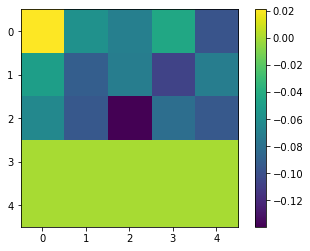

In [22]:
mode = 0
plt.imshow( conv_plot.detach().cpu().numpy().real[1,1,:,:] )
plt.colorbar()
#plt.savefig('./images/filters/fno_' + 'conv5_' + str(mode) + '_re')

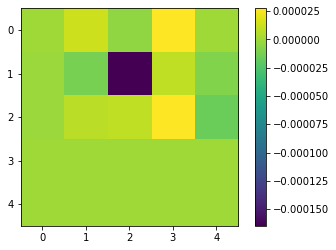

In [25]:
plt.imshow( conv_plot.detach().cpu().numpy().imag[4,4,:,:] )
plt.colorbar()
#plt.savefig('.

In [19]:
w_num = 5
w_plot = model_fno.w5.state_dict()['weight']
print(w_plot.shape)

torch.Size([64, 64, 1, 1])


In [ ]:
plt.imshow( w_plot.detach().cpu().numpy()[:,:,0,0] )
plt.colorbar()

plt.savefig('./images/filters/fno_' + 'w' + str(w_num) )

In [ ]:
# LINEAR PLOT
w_plot = model_fno.w7.state_dict()['weight']
print(w_plot.shape)
plt.imshow( w_plot.detach().cpu().numpy()[:,:,0,0] )

In [ ]:
# LINEAR PLOT
w_plot = model_fno.conv7.state_dict()['weights1']
print(w_plot.shape)
plt.imshow( w_plot.detach().cpu().numpy().real[:,:,0,0] )

#plt.savefig('./images/fno_'+'weights_' + +'_real')

In [ ]:
plt.savefig('./images/gn_'+'boxplot_'+str(metric_type))

# ConvNet Filters

In [ ]:
# CNN MODEL TRAINING
############################################################################
train_loader, test_loader = normalize_data_cnn(0)

model = CNN().cuda()
no_param_cnn = count_params(model)
print(no_param_cnn)
output = train_model(model, 20, batch_size, learning_rate, weight_decay, step_size, gamma, train_loader, test_loader)
time_cnn  = round(output.get('training_time'),2)
model_cnn = output.get("model")

In [ ]:
print('CNN')
start = timeit.default_timer()
results_cnn = model_metrics(model_cnn,test_loader,ntrain)
infer_time_cnn = timeit.default_timer() - start

In [ ]:
model_cnn.type

In [ ]:
print(model_cnn.conv1.state_dict().keys(),'\n')

In [ ]:
w_plot = model_cnn.conv2.state_dict()['weight']
print(w_plot.shape)
plt.imshow( w_plot.detach().cpu().numpy()[:,:,0,0] )
plt.colorbar()

#plt.savefig('./images/filters/cnn_w2')

In [ ]:
# First Layer
w_plot = model_cnn.conv1.state_dict()['weight']
print(w_plot.shape)
temp = w_plot.detach().cpu().numpy()[0,0,:,:]

plt.imshow(temp)
plt.colorbar()

#plt.imshow( temp.reshape(8,16) )
#plt.colorbar(fraction=0.047*(0.5))

plt.savefig('./images/filters/cnn_kernel1')


In [ ]:
# Final Layer
w_plot = model_cnn.conv3.state_dict()['weight']
print(w_plot.shape)
temp = w_plot.detach().cpu().numpy()[0,:,0,0]

plt.imshow( temp.reshape(8,16))
plt.colorbar(fraction=0.047*(0.5))

plt.savefig('./images/filters/cnn_w3')
